In [3]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import gzip
from scipy.io import mmread
import matplotlib.pyplot as plt
import huffman
from bitstring import BitStream

In [30]:
datasets = ['humanBloodCells', 'humanKidneyCells', 'humanSkinCells']
dataset_index = 0
with gzip.open('./data/' + datasets[dataset_index] + '/matrix.mtx.gz', 'rt') as f:
  matrix = np.array(mmread(f).todense())
  features = pd.read_csv('./data/' + datasets[dataset_index] + '/features.tsv.gz', sep='\t')
  barcodes = pd.read_csv('./data/' + datasets[dataset_index] + '/barcodes.tsv.gz', sep='\t')

In [5]:
num_nonzero = np.count_nonzero(matrix)
sparsity = np.count_nonzero(matrix) / matrix.size
print('Number of non-zero entries:', num_nonzero)
print('Matrix shape:', matrix.shape)
print('Sparsity:', f'{sparsity * 100}%')

Number of non-zero entries: 11598877
Matrix shape: (4661, 38616)
Sparsity: 6.444208067267334%


(array([1.15895e+07, 7.44100e+03, 1.01100e+03, 3.95000e+02, 2.03000e+02,
        9.60000e+01, 6.00000e+01, 3.90000e+01, 2.50000e+01, 1.40000e+01,
        9.00000e+00, 8.00000e+00, 8.00000e+00, 6.00000e+00, 4.00000e+00,
        2.00000e+00, 3.00000e+00, 2.00000e+00, 2.00000e+00, 2.00000e+00,
        3.00000e+00, 2.00000e+00, 1.00000e+00, 3.00000e+00, 3.00000e+00,
        3.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00, 3.00000e+00,
        0.00000e+00, 0.00000e+00, 2.00000e+00, 3.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00, 0.00000e+00,
        2.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00, 2.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00

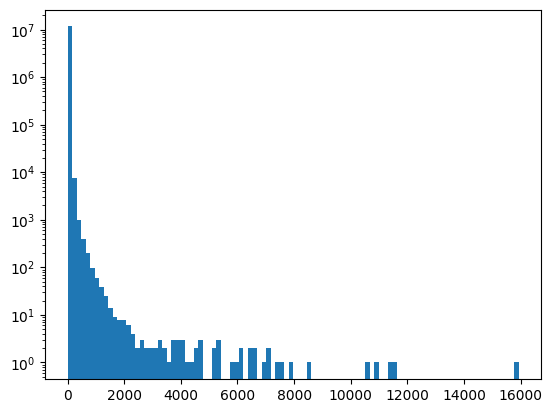

In [4]:
non_zero_vals = [i for i in matrix.reshape(matrix.size).tolist() if i != 0]
plt.hist(non_zero_vals, bins=100, log=True)

In [19]:
def kmeans_structures(matrix, n_clusters):
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(matrix)

  # Identify cluster representatives
  min_dists = np.zeros(n_clusters)
  reps = np.array([-1 for i in range(n_clusters)])
  for i in range(matrix.shape[0]):
    curr_dist = np.linalg.norm(matrix[i] - kmeans.cluster_centers_[kmeans.labels_[i]])
    if reps[kmeans.labels_[i]] == -1 or curr_dist < min_dists[kmeans.labels_[i]]:
      min_dists[kmeans.labels_[i]] = curr_dist
      reps[kmeans.labels_[i]] = i

  # Get delta matrix
  delta_matrix = np.copy(matrix)
  for i in range(matrix.shape[0]):
    if reps[kmeans.labels_[i]] == i:
      continue
    delta_matrix[i] -= matrix[reps[kmeans.labels_[i]]]

  return reps, kmeans.labels_, delta_matrix

In [20]:
def encode_huffman_tree(root, bits_per_val, bitarray):
  if type(root) == huffman.Leaf:
    bitarray.append('0b1')
    bitarray.append('0b1' if root.symbol < 0 else '0b0')
    bitarray.append(f'0b{bin(abs(root.symbol))[2:].zfill(bits_per_val)}')
    return
  bitarray.append('0b0')
  encode_huffman_tree(root.left, bits_per_val, bitarray)
  encode_huffman_tree(root.right, bits_per_val, bitarray)

In [21]:
def decode_huffman_tree(bitstream, bits_per_val):
  if bitstream.read(1) == '0b1':
    mult = -1 if bitstream.read(1) == '0b1' else 1
    val = mult * int(bitstream.read(f'bin{bits_per_val}'), 2)
    return huffman.Leaf(val, 0)
  left = decode_huffman_tree(bitstream, bits_per_val)
  right = decode_huffman_tree(bitstream, bits_per_val)
  return huffman.Node(left, right)

In [22]:
def read_huffman_tree(root, bitstream):
  if type(root) == huffman.Leaf:
    return root.symbol
  elif bitstream.read(1) == '0b0':
    return read_huffman_tree(root.left, bitstream)
  return read_huffman_tree(root.right, bitstream)

In [ ]:
def encode_rle(bitstream):
  with open('./results/humanBloodCells_50.bin', 'rb') as f:
    bitstream = BitStream(f.read())

  run_lengths = {}
  curr_bit = -1
  run_len = 0
  rle_bitstream = BitStream()
  for i in range(bitstream.length):
    bit = 1 if bitstream.read(1) == '0b1' else 0
    if bit == curr_bit:
      run_len += 1
    else:
      if curr_bit == -1:
        rle_bitstream.append(f'0b{bit}')
      else:
        rle_bitstream.append(f'0b{bin(run_len)[2:].zfill(run_len.bit_length() * 2 - 1)}')
      curr_bit = bit
      if run_len not in run_lengths:
        run_lengths[run_len] = 0
      run_lengths[run_len] += 1
      run_len = 1
  del run_lengths[0]
  return rle_bitstream, run_lengths
rle_bitstream, run_lengths = encode_rle(None)
print('rle length', rle_bitstream.length)

rle length 333655929


<BarContainer object of 22 artists>

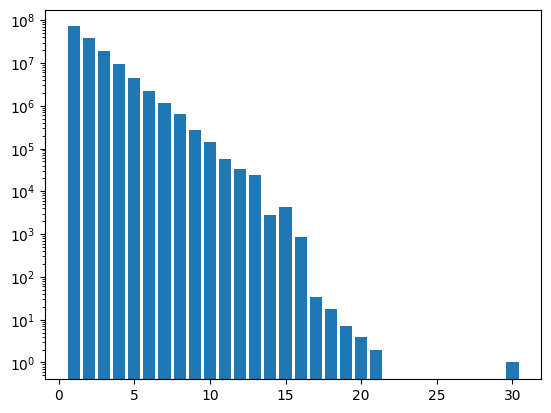

In [17]:
lens = []
freqs = []
for k, v in run_lengths.items():
  lens.append(k)
  freqs.append(v)
plt.bar(lens, freqs, log=True)

In [ ]:
def decode_rle(bitstream):
  pass

In [27]:
SIZE_BITS = 32
METADATA_BITS = 8

def kmeans_compression(kmeans_data, output_filename):
  reps, labels, delta_matrix = kmeans_data
  n_clusters = len(reps)
  bitstream = BitStream()

  # Compress metadata values
  bitstream.append(f'uint{SIZE_BITS}={delta_matrix.shape[0]}')
  bitstream.append(f'uint{SIZE_BITS}={delta_matrix.shape[1]}')
  bitstream.append(f'uint{METADATA_BITS}={n_clusters}')

  bits_per_m_index = delta_matrix.shape[0].bit_length()
  bits_per_n_index = delta_matrix.shape[1].bit_length()
  bits_per_cluster_index = n_clusters.bit_length()

  # Compress cluster membership information
  for rep in reps:
    bitstream.append(f'bin{bits_per_m_index}={bin(rep)[2:].zfill(bits_per_m_index)}')

  for label in labels:
    bitstream.append(f'bin{bits_per_cluster_index}={bin(label)[2:].zfill(bits_per_cluster_index)}')

  # Huffman Encoding
  freqs = {}
  bits_per_huffman_val = 0
  for i in range(delta_matrix.shape[0]):
    for j in range(delta_matrix.shape[1]):
      bits_per_huffman_val = max(bits_per_huffman_val, int(delta_matrix[i][j]).bit_length())
      if delta_matrix[i][j] != 0:
        if delta_matrix[i][j] not in freqs:
          freqs[delta_matrix[i][j]] = 0
        freqs[delta_matrix[i][j]] += 1
  freqs = [(int(k), v) for k, v in freqs.items()]
  huffman_tree = huffman.Tree(freqs)
  huffman_codebook = huffman_tree.codebook
  bitstream.append(f'uint{METADATA_BITS}={bits_per_huffman_val}')  
  encode_huffman_tree(huffman_tree.root, bits_per_huffman_val, bitstream)

  # Compress delta matrix
  for i in range(delta_matrix.shape[0]):
    row = delta_matrix[i]
    num_nonzero = np.count_nonzero(row)
    bitstream.append(f'bin{bits_per_n_index}={bin(num_nonzero)[2:].zfill(bits_per_n_index)}')
    for j in range(delta_matrix.shape[1]):
      if row[j] == 0:
        continue
      bitstream.append(f'bin{bits_per_n_index}={bin(j)[2:].zfill(bits_per_n_index)}')
      bitstream.append(f'0b{huffman_codebook[row[j]]}')
  
  with open(output_filename, 'wb') as f:
    f.write(bytes(bitstream))

def kmeans_decompression(input_filename):
  with open(input_filename, 'rb') as f:
    bitstream = BitStream(f.read())

  # Decompress metadata
  m = bitstream.read(f'uint{SIZE_BITS}')
  n = bitstream.read(f'uint{SIZE_BITS}')
  n_clusters = bitstream.read(f'uint{METADATA_BITS}')

  bits_per_m_index = m.bit_length()
  bits_per_n_index = n.bit_length()
  bits_per_cluster_index = n_clusters.bit_length()
  
  # Decompress cluster membership information
  reps = []
  for i in range(n_clusters):
    reps.append(int(bitstream.read(f'bin{bits_per_m_index}'), 2))

  labels = []
  for i in range(m):
    labels.append(int(bitstream.read(f'bin{bits_per_cluster_index}'), 2))

  # Decompress Huffman tree
  huffman_tree = decode_huffman_tree(bitstream, bitstream.read(f'uint{METADATA_BITS}'))

  # Decompress delta matrix
  matrix = np.zeros((m, n))
  for i in range(m):
    num_nonzero = int(bitstream.read(f'bin{bits_per_n_index}'), 2)
    for j in range(num_nonzero):
      index = int(bitstream.read(f'bin{bits_per_n_index}'), 2)
      val = read_huffman_tree(huffman_tree, bitstream)
      matrix[i][index] = val
  
  # Reconstruct original matrix
  for i in range(m):
    if reps[labels[i]] == i:
      continue
    matrix[i] += matrix[reps[labels[i]]]
  return matrix

In [ ]:
k_vals = [1, 5, 10, 25, 50, 75, 100]
for k in k_vals:
  kmeans_compression(kmeans_structures(matrix, k), f'./results/{datasets[dataset_index]}/normal/{datasets[dataset_index]}_{k}.bin')
  kmeans_compression(kmeans_structures(np.transpose(matrix), k), f'./results/{datasets[dataset_index]}/transpose/{datasets[dataset_index]}_transpose_{k}.bin')